# Plotting
> Plot the result of CF explanations.

In [ ]:
#| default_exp plotting

In [ ]:
#| include: false
%load_ext autoreload
%autoreload 2
from ipynb_path import *

In [ ]:
#| export
from __future__ import annotations
from cfnet.import_essentials import *
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
#| export
def swarmplot(
        X, # Factual data
        cfs, # Counterfactual examples
        dm: TabularDataModule, # Data module, containing info for columns
        plot_name: str,  # The name for the plot
        sample_num: int,  # The number of sample for the plot
        seed: int,  # Seed for PRG for random sampling
        separate_class: bool, # Whether to separate the data based on the classifier result
        pred_fn: Callable[[jnp.DeviceArray], jnp.DeviceArray], # Predict function
    ):

    # Compute the difference of continuous data between factual and counterfactual
    X_inverse = dm.normalizer.inverse_transform(X[:, :dm.cat_idx])
    cf_inverse = dm.normalizer.inverse_transform(cfs[:, :dm.cat_idx])
    diff = jnp.subtract(cf_inverse, X_inverse)

    # Configuration for randomized sampling
    data_len: int = len(X)  # Length of the dataset
    key_seq: hk.PRNGSequence = hk.PRNGSequence(
        seed
    )  # Random number sequence
    key_seq.reserve(
        sample_num
    )  # Generate some random number as key based on the number of batches
    indices: jnp.array = jnp.arange(
        data_len
    )  # Available indices in the dataset
    y_pred = pred_fn(X).reshape(-1, 1)
    y_pred = y_pred.reshape(-1)
    y_pred = np.rint(y_pred)
    if 1 in y_pred:
        one_indices = jnp.array([i for i, x in enumerate(y_pred) if x == 1])
    if 0 in y_pred:
        zero_indices = jnp.array([i for i, x in enumerate(y_pred) if x == 0])

    # Preparing the data for plotting
    key = next(key_seq) # Obtain a random key from the sequence
    indices = jax.random.permutation(key, indices)  # Shuffled available indices
    if not separate_class:
        sampled_data = jnp.asarray([diff[i] for i in indices[: sample_num]]) # sampled data
        data = dict()  # Data for the plot
        for f in range(len(dm.continous_cols)):
            data[dm.continous_cols[f]] = sampled_data[:,f]
        df = pd.DataFrame(data)

        # Create the plot
        sns.set(style="whitegrid")
        ax = sns.swarmplot(
                x="variable",
                y="value",
                data=df.melt(),
                alpha=0.5,
                size=5).set(title=plot_name, xlabel='Features', ylabel='Difference')
        plt.show(ax)
    else:
        if 1 in y_pred:
            one_indices = jax.random.permutation(key, one_indices) # Shuffle available indices
            sampled_data_one = jnp.asarray(diff[one_indices[: sample_num]]) # sampled data
            data_one = dict()  # Data for the plot
        if 0 in y_pred:
            zero_indices = jax.random.permutation(key, zero_indices) # Shuffle available indices
            sampled_data_zero = jnp.asarray(diff[zero_indices[: sample_num]]) # sampled data
            data_zero = dict()  # Data for the plot

        for f in range(len(dm.continous_cols)):
            if 0 in y_pred:
                data_zero[dm.continous_cols[f]] = sampled_data_zero[:,f]
            if 1 in y_pred:
                data_one[dm.continous_cols[f]] = sampled_data_one[:,f]
        if 1 in y_pred:
            df_one = pd.DataFrame(data_one)
        if 0 in y_pred:
            df_zero = pd.DataFrame(data_zero)

        # Create the plot
        sns.set(style="whitegrid")
        fig, axes = plt.subplots(1, 2, figsize=(18, 10))
        if 0 in y_pred:
            sns.swarmplot(
                    x="variable",
                    y="value",
                    data=df_zero.melt(),
                    alpha=0.5,
                    size=5,
                    ax=axes[0]).set(title=plot_name+" Zero to One", xlabel='Features', ylabel='Difference')
        if 1 in y_pred:
            sns.swarmplot(
                    x="variable",
                    y="value",
                    data=df_one.melt(),
                    alpha=0.5,
                    size=5,
                    ax=axes[1]).set(title=plot_name+" One to Zero", xlabel='Features', ylabel='Difference')
        plt.show(fig)


def stripplot(
        X, # Factual data
        cfs, # Counterfactual examples
        dm: TabularDataModule, # Data module, containing info for columns
        plot_name: str,  # The name for the plot
        sample_num: int,  # The number of sample for the plot
        seed: int,  # Seed for PRG for random sampling
        separate_class: bool, # Whether to separate the data based on the classifier result
        pred_fn: Callable[[jnp.DeviceArray], jnp.DeviceArray], # Predict function
    ):

    # Obtain discrete data
    X_dis = X[:,dm.cat_idx:]
    cf_dis = cfs[:,dm.cat_idx:]

    # Configuration for randomized sampling
    data_len: int = len(X)  # Length of the dataset
    key_seq: hk.PRNGSequence = hk.PRNGSequence(
        seed
    )  # Random number sequence
    key_seq.reserve(
        sample_num
    )  # Generate some random number as key based on the number of batches
    indices: jnp.array = jnp.arange(
        data_len
    )  # Available indices in the dataset
    y_pred = pred_fn(X).reshape(-1, 1)
    y_pred = y_pred.reshape(-1)
    y_pred = np.rint(y_pred)
    if 0 in y_pred:
        zero_indices = jnp.array([i for i, x in enumerate(y_pred) if x == 0])
    if 1 in y_pred:
        one_indices = jnp.array([i for i, x in enumerate(y_pred) if x == 1])

    key = next(key_seq) # Obtain a random key from the sequence
    # For sparating the points on the plot
    jitter = 0.3
    delta = np.random.uniform(-jitter / 2, jitter / 2, sample_num)
    if not separate_class:
        indices = jax.random.permutation(key, indices) # Shuffle available indices
        sampled_data = jnp.asarray(X_dis[indices[: sample_num]]) # Sampled factual data
        sampled_cfs = jnp.asarray(cf_dis[indices[: sample_num]]) # Sampled counterfactual data
        data = dict() # Data for the plot
        for feature in dm.discret_cols:
            data[feature] = []

        # Preparing the data for plotting
        for i in range(sample_num):
            cat_idx = 0
            for f in range(len(dm.cat_arrays)):
                feature = dm.discret_cols[f]
                l = len(dm.cat_arrays[f])
                cat_end = cat_idx + l
                if jnp.array_equal(sampled_data[i][cat_idx:cat_end], sampled_cfs[i][cat_idx:cat_end]):
                    data[feature].append(0+delta[i])
                else:
                    data[feature].append(1+delta[i])
                cat_idx += l

        df = pd.DataFrame(data)
        sns.set(style="whitegrid")
        ax = sns.stripplot(
                y="variable",
                x="value",
                data=df.melt(),
                alpha=0.5,
                size=7,
                jitter=jitter).set(title=plot_name, xlabel='Difference', ylabel='Features')
        plt.show(ax)
    else:
        if 0 in y_pred:
            zero_indices = jax.random.permutation(key, zero_indices) # Shuffle available indices
            zero_sampled_data = jnp.asarray(X_dis[zero_indices[: sample_num]]) # Sampled factual data
            zero_sampled_cfs = jnp.asarray(cf_dis[zero_indices[: sample_num]]) # Sampled counterfactual data
            data_zero = dict() # Data for the plot
        if 1 in y_pred:
            one_indices = jax.random.permutation(key, one_indices) # Shuffle available indices
            one_sampled_data = jnp.asarray(X_dis[one_indices[: sample_num]]) # Sampled factual data
            one_sampled_cfs = jnp.asarray(cf_dis[one_indices[: sample_num]]) # Sampled counterfactual data
            data_one = dict() # Data for the plot

        data_zero = {}
        data_one = {}

        for feature in dm.discret_cols:
            if 1 in y_pred:
                data_one[feature] = []
            if 0 in y_pred:
                data_zero[feature] = []

        # Preparing the data for plotting
        for i in range(sample_num):
            cat_idx = 0
            for f in range(len(dm.cat_arrays)):
                feature = dm.discret_cols[f]
                l = len(dm.cat_arrays[f])
                cat_end = cat_idx + l
                if data_zero:
                    if jnp.array_equal(zero_sampled_data[i][cat_idx:cat_end], zero_sampled_cfs[i][cat_idx:cat_end]):
                        data_zero[feature].append(0+delta[i])
                    else:
                        data_zero[feature].append(1+delta[i])
                if data_one:
                    if jnp.array_equal(one_sampled_data[i][cat_idx:cat_end], one_sampled_cfs[i][cat_idx:cat_end]):
                        data_one[feature].append(0+delta[i])
                    else:
                        data_one[feature].append(1+delta[i])
                cat_idx += l
        if data_zero:
            df_zero = pd.DataFrame(data_zero)
        if data_one:
            df_one = pd.DataFrame(data_one)
        sns.set(style="whitegrid")
        fig, axes = plt.subplots(1, 2, figsize=(18, 10))
        if data_zero:
            sns.stripplot(
                    ax=axes[0],
                    y="variable",
                    x="value",
                    data=df_zero.melt(),
                    alpha=0.5,
                    size=7,
                    jitter=jitter).set(title=plot_name+" Zero to One", xlabel='Difference', ylabel='Features')
        if data_one:
            sns.stripplot(
                    ax=axes[1],
                    y="variable",
                    x="value",
                    data=df_one.melt(),
                    alpha=0.5,
                    size=7,
                    jitter=jitter).set(title=plot_name+" One to Zero", xlabel='Difference', ylabel='Features')
        plt.show(fig)

def barplot(
        X, # Single factual data
        cf, # Single counterfactual examples
        dm: TabularDataModule, # Data module, containing info for columns
        plot_name: str  # The name for the plot
    ):
    # Check the dimension of both data
    if X.ndim != 1:
        raise ValueError(
            "The factual data is not appropriately configured."
        )
    if cf.ndim != 1:
        raise ValueError(
            "The counterfactual data is not appropriately configured."
        )
    features = dm.continous_cols.copy()
    features.extend(dm.discret_cols)  # the complete set of features for plotting
    data = dict()  # data for plotting

    # Convert normalized data, and store in data
    X_inverse = dm.normalizer.inverse_transform(X[:dm.cat_idx].reshape(1, -1))
    cf_inverse = dm.normalizer.inverse_transform(cf[:dm.cat_idx].reshape(1, -1))
    cont_diff = jnp.subtract(cf_inverse,X_inverse).tolist()
    for f in range(len(dm.continous_cols)):
        data[dm.continous_cols[f]] = cont_diff[0][f]

    # Convert one hot encoded data, and store in data
    cat_idx = dm.cat_idx
    for f in range(len(dm.cat_arrays)):
        l = len(dm.cat_arrays[f])
        cat_end = cat_idx + l
        if jnp.array_equal(X[cat_idx:cat_end], cf[cat_idx:cat_end]):
            data[dm.discret_cols[f]]=0
        else:
            data[dm.discret_cols[f]]=1
        cat_idx += l

    # Plot the figure
    # Adapt from https://www.geeksforgeeks.org/bar-plot-in-matplotlib/
    # Figure Size
    fig, ax = plt.subplots(figsize =(16, 9))

    # Horizontal Bar Plot
    ax.barh(list(data.keys()), list(data.values()))

    # Remove axes splines
    for s in ['top', 'bottom', 'left', 'right']:
        ax.spines[s].set_visible(False)

    # Remove x, y Ticks
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

    # Add padding between axes and labels
    ax.xaxis.set_tick_params(pad = 5)
    ax.yaxis.set_tick_params(pad = 10)

    # Add x, y gridlines
    ax.grid(b = True, color ='grey',
            linestyle ='-.', linewidth = 0.5,
            alpha = 0.2)

    # Show top values
    ax.invert_yaxis()

    # Add annotation to bars
    for i in ax.patches:
        plt.text(i.get_width()+0.2, i.get_y()+0.5,
                 str(round((i.get_width()), 2)),
                 fontsize = 10, fontweight ='bold',
                 color ='grey')
    # Add Plot Title
    ax.set_title(plot_name,
                 loc ='left', )
    plt.show()

## Test

In [ ]:
from cfnet.module import PredictiveTrainingModule
from cfnet.utils import load_json
from cfnet.datasets import TabularDataModule

In [ ]:
#| slow
configs = load_json('assets/configs/data_configs/adult.json')
m_configs = configs['mlp_configs']
data_configs = configs['data_configs']
data_configs['sample_frac'] = 0.1
training_module = PredictiveTrainingModule(m_configs)
dm = TabularDataModule(data_configs)

params, opt_state = train_model(
    training_module,
    dm,
    t_configs
)
pred_fn = lambda x, params, prng_key: training_module.forward(params, prng_key, x, is_training=False)
t_configs = {
    'n_epochs': 10,
    'monitor_metrics': 'val/val_loss',
    'seed': 42,
    "batch_size": 256
}

Epoch 9: 100%|██████████| 10/10 [00:00<00:00, 134.74batch/s, train/train_loss_1=0.0922]


In [ ]:
#| slow
training_module = PredictiveTrainingModule(m_configs)
dm = TabularDataModule(data_configs)

params, opt_state = train_model(
    training_module,
    dm,
    t_configs
)
pred_fn = lambda x, params, prng_key: \
    training_module.forward(params, prng_key, x, is_training=False)

Epoch 9: 100%|██████████| 10/10 [00:00<00:00, 122.01batch/s, train/train_loss_1=0.0842]


In [ ]:
from cfnet.methods import VanillaCF, CounterNet
from cfnet.evaluate import generate_cf_explanations

### VanillaCF

In [ ]:
#| slow
vanillacf = VanillaCF(dict(n_steps=1000, lr=0.001))
cf_results = generate_cf_explanations(
    vanillacf, dm, pred_fn,
    pred_fn_args=dict(params=params, prng_key=random.PRNGKey(0))
)

100%|██████████| 1000/1000 [00:05<00:00, 197.80it/s]


/var/folders/82/4qh59pkn75xdzh4r61851p4h0000gn/T/ipykernel_20751/2829834592.py:287: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


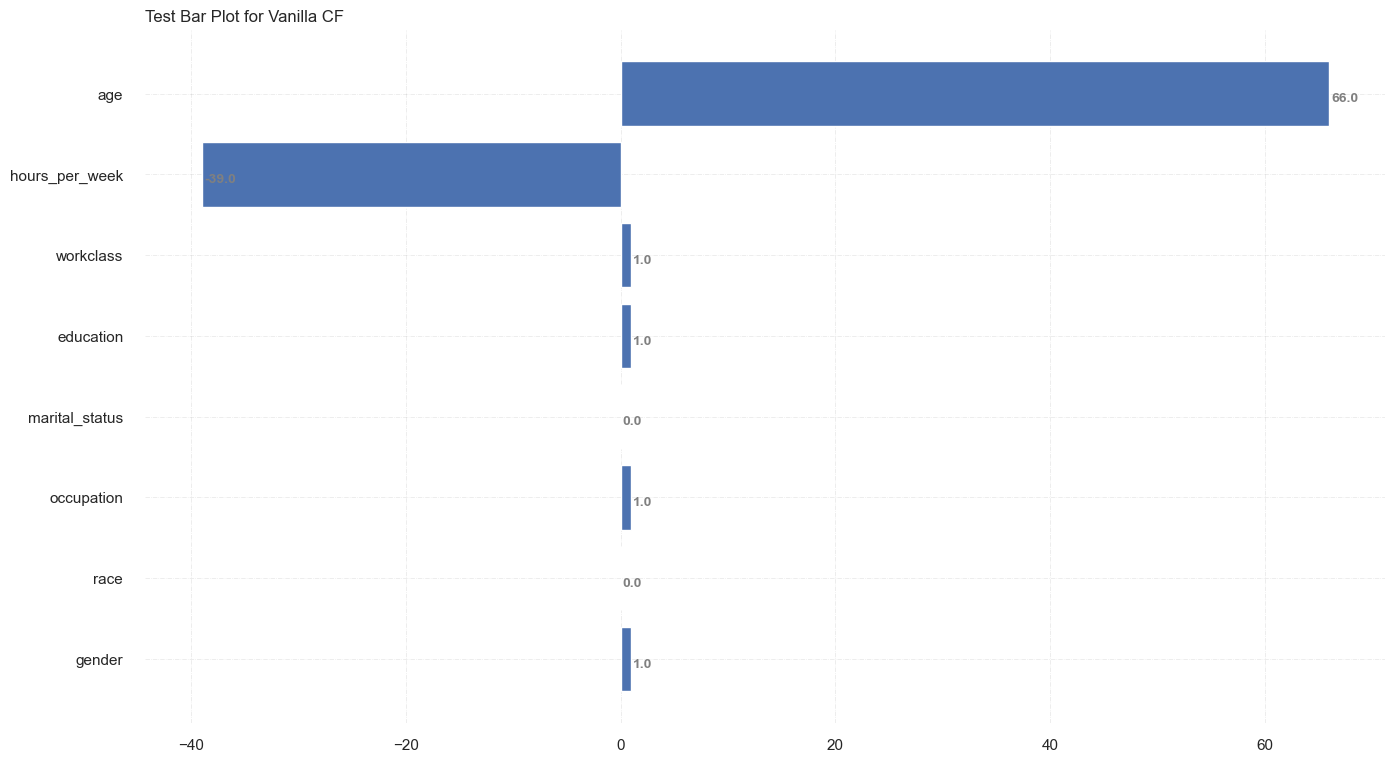

In [ ]:
#| slow
X, y = cf_results.data_module.test_dataset[:]
barplot(X[150], cf_results.cfs[150], dm, "Test Bar Plot for Vanilla CF")

/Users/chuck/opt/anaconda3/envs/cfnet/lib/python3.8/site-packages/seaborn/categorical.py:3543: UserWarning: 30.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/chuck/opt/anaconda3/envs/cfnet/lib/python3.8/site-packages/seaborn/categorical.py:3543: UserWarning: 39.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


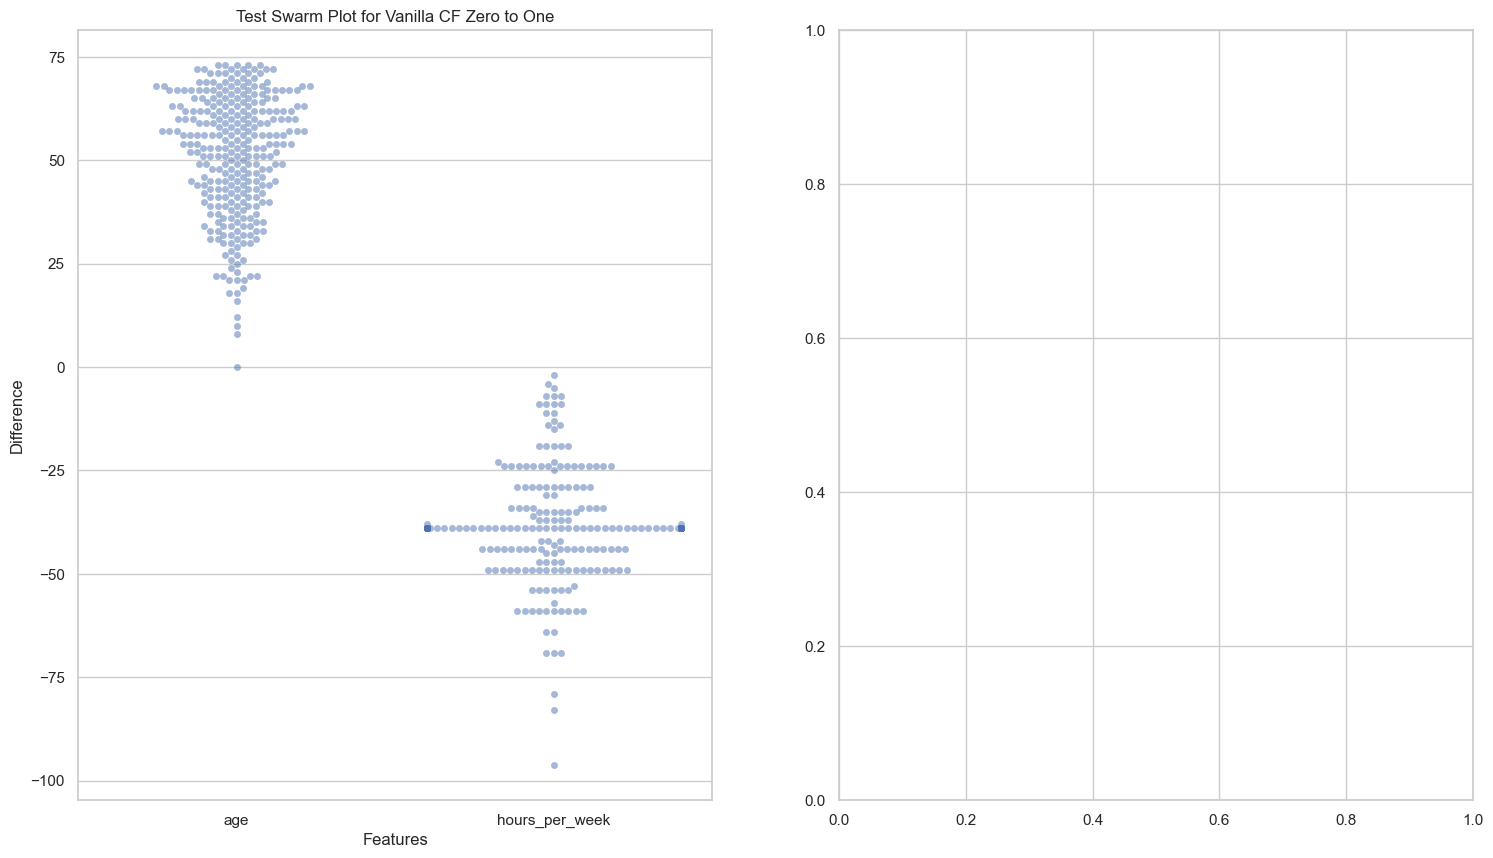

/Users/chuck/opt/anaconda3/envs/cfnet/lib/python3.8/site-packages/seaborn/categorical.py:3543: UserWarning: 36.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/chuck/opt/anaconda3/envs/cfnet/lib/python3.8/site-packages/seaborn/categorical.py:3543: UserWarning: 7.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/chuck/opt/anaconda3/envs/cfnet/lib/python3.8/site-packages/seaborn/categorical.py:3543: UserWarning: 43.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


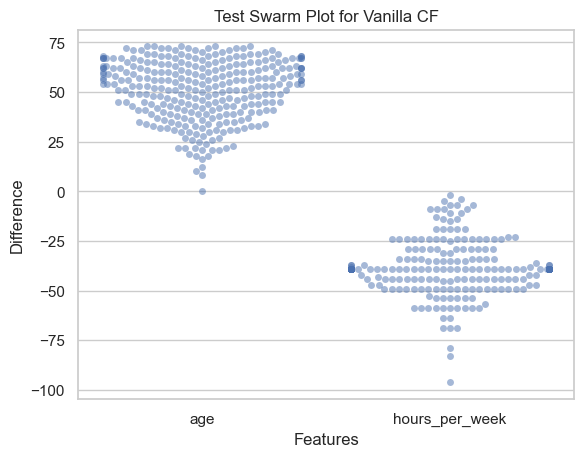

In [ ]:
#| slow
X, y = cf_results.data_module.test_dataset[:]
swarmplot(X, cf_results.cfs, dm, "Test Swarm Plot for Vanilla CF", 300, 42, True, cf_results.pred_fn)
swarmplot(X, cf_results.cfs, dm, "Test Swarm Plot for Vanilla CF", 300, 42, False, cf_results.pred_fn)

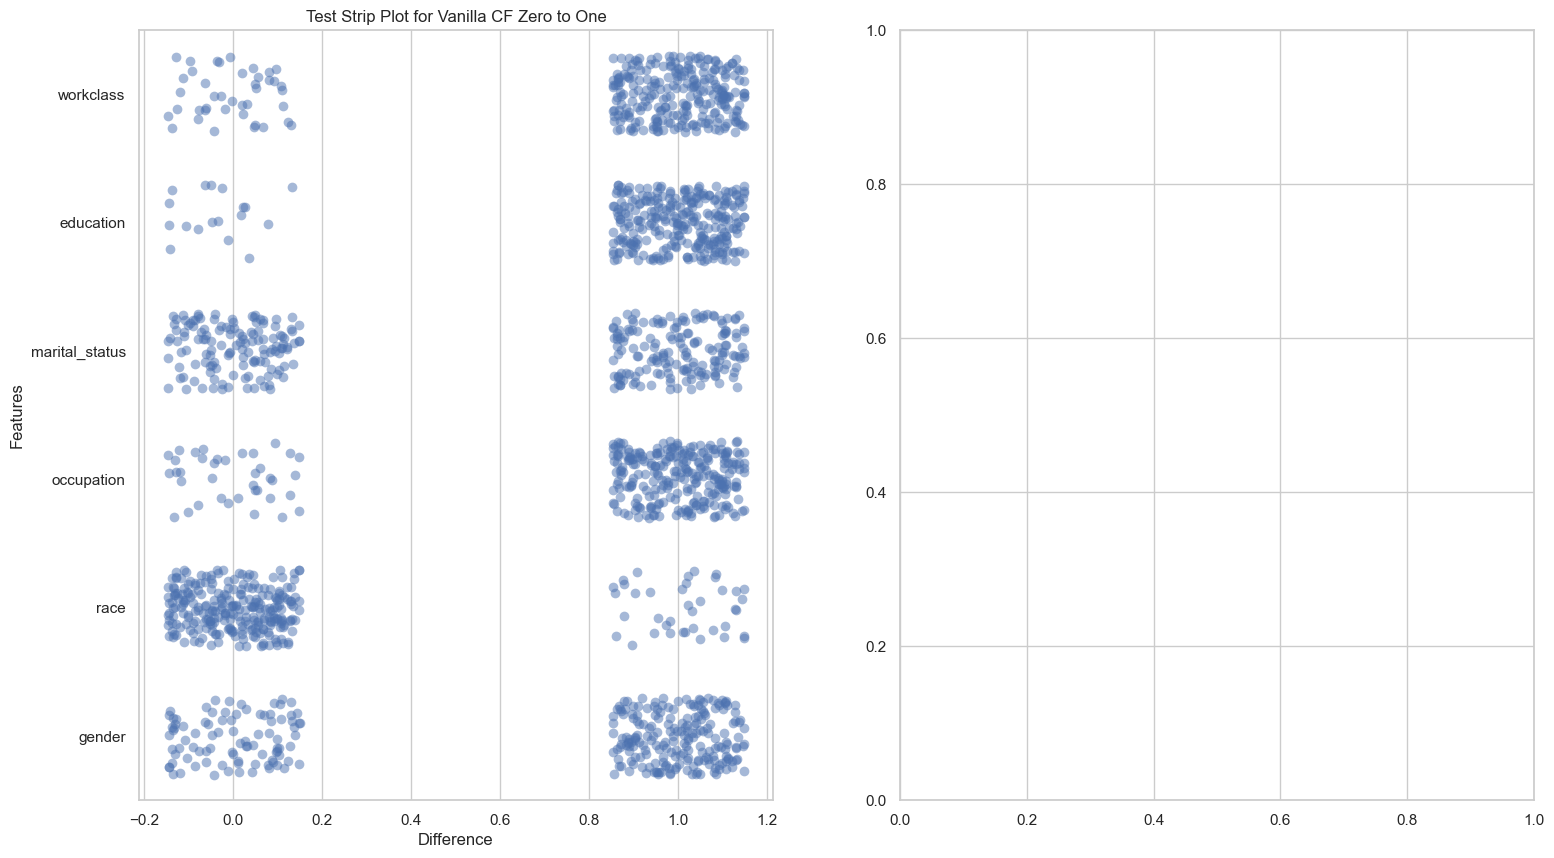

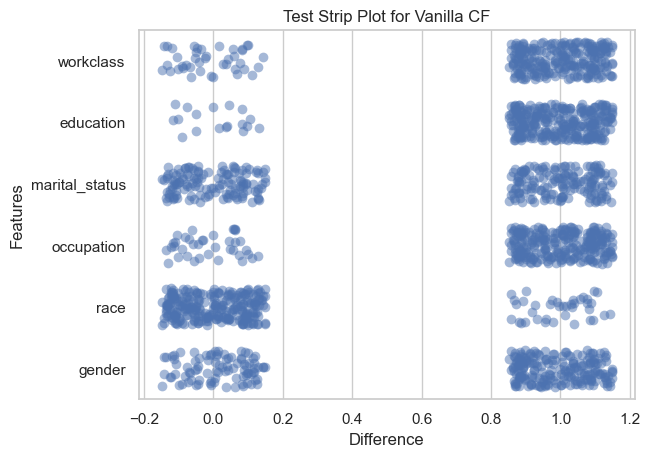

In [ ]:
#| slow
X, y = cf_results.data_module.test_dataset[:]
stripplot(X, cf_results.cfs, dm, "Test Strip Plot for Vanilla CF", 300, 42, True, cf_results.pred_fn)
stripplot(X, cf_results.cfs, dm, "Test Strip Plot for Vanilla CF", 300, 42, False, cf_results.pred_fn)

## CounterNet

In [ ]:
#| slow
counternet = CounterNet()
counternet_exp = generate_cf_explanations(counternet, dm, pred_fn=None)

CounterNet contains parametric models. Starts training before generating explanations...


Epoch 99: 100%|██████████| 20/20 [00:00<00:00, 186.31batch/s, train/train_loss_1=0.0497, train/train_loss_2=9.43e-5, train/train_loss_3=0.099]   


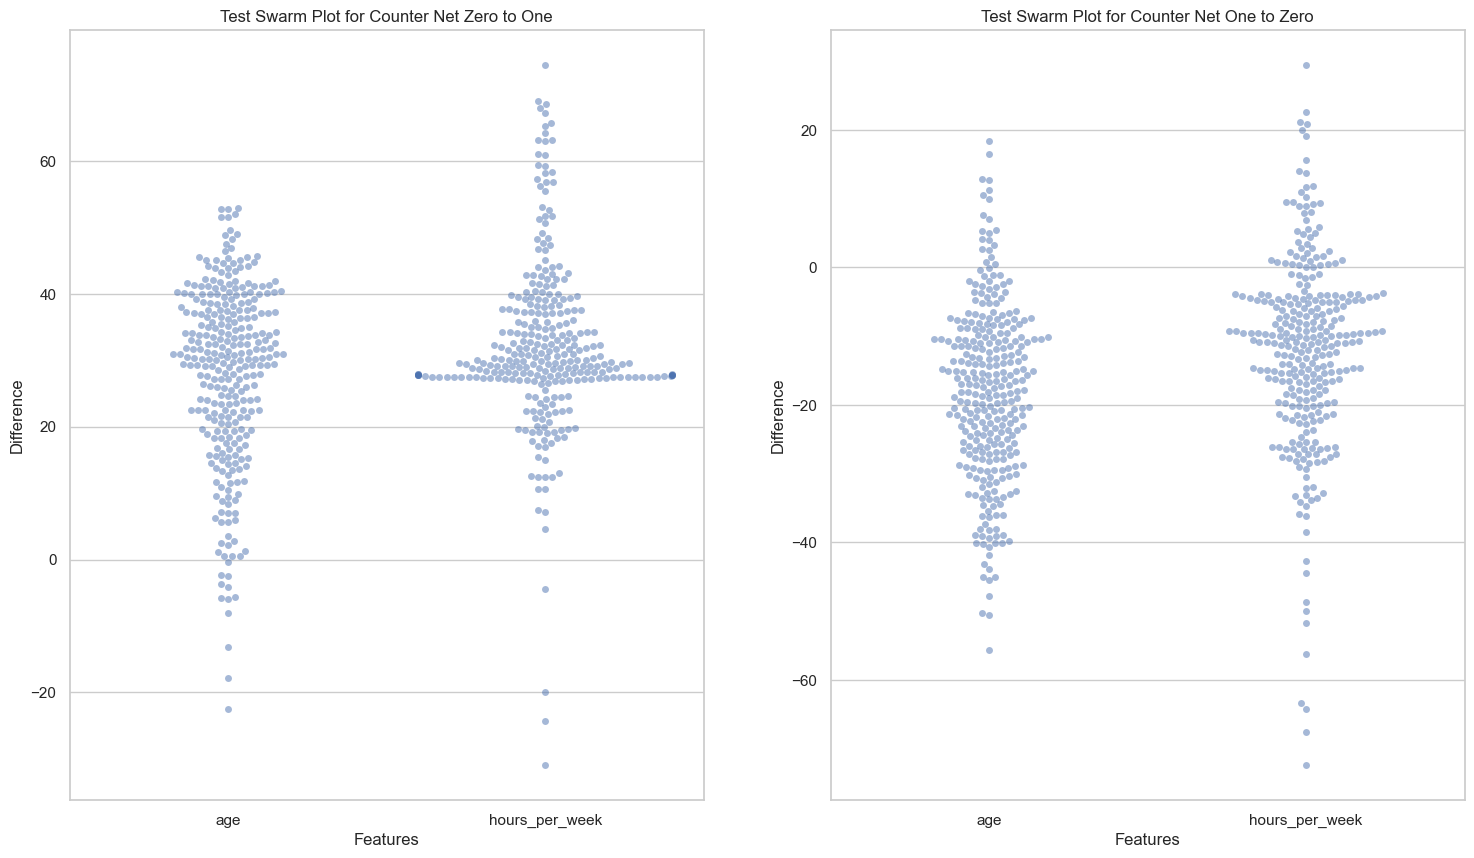

/Users/chuck/opt/anaconda3/envs/cfnet/lib/python3.8/site-packages/seaborn/categorical.py:3543: UserWarning: 15.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


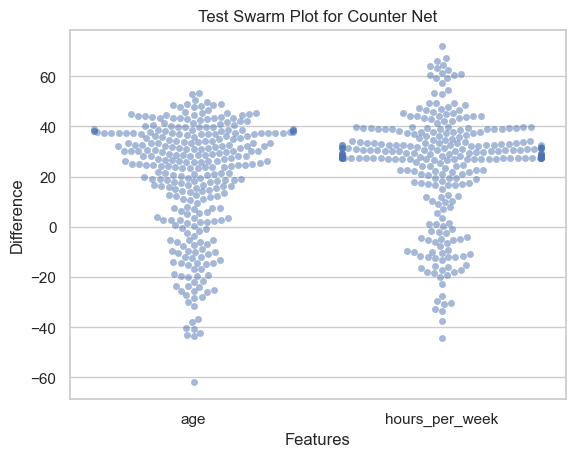

In [ ]:
#| slow
X, y = counternet_exp.data_module.test_dataset[:]
swarmplot(X, counternet_exp.cfs, dm, "Test Swarm Plot for Counter Net", 300, 42, True, counternet_exp.pred_fn)
swarmplot(X, counternet_exp.cfs, dm, "Test Swarm Plot for Counter Net", 300, 42, False, counternet_exp.pred_fn)

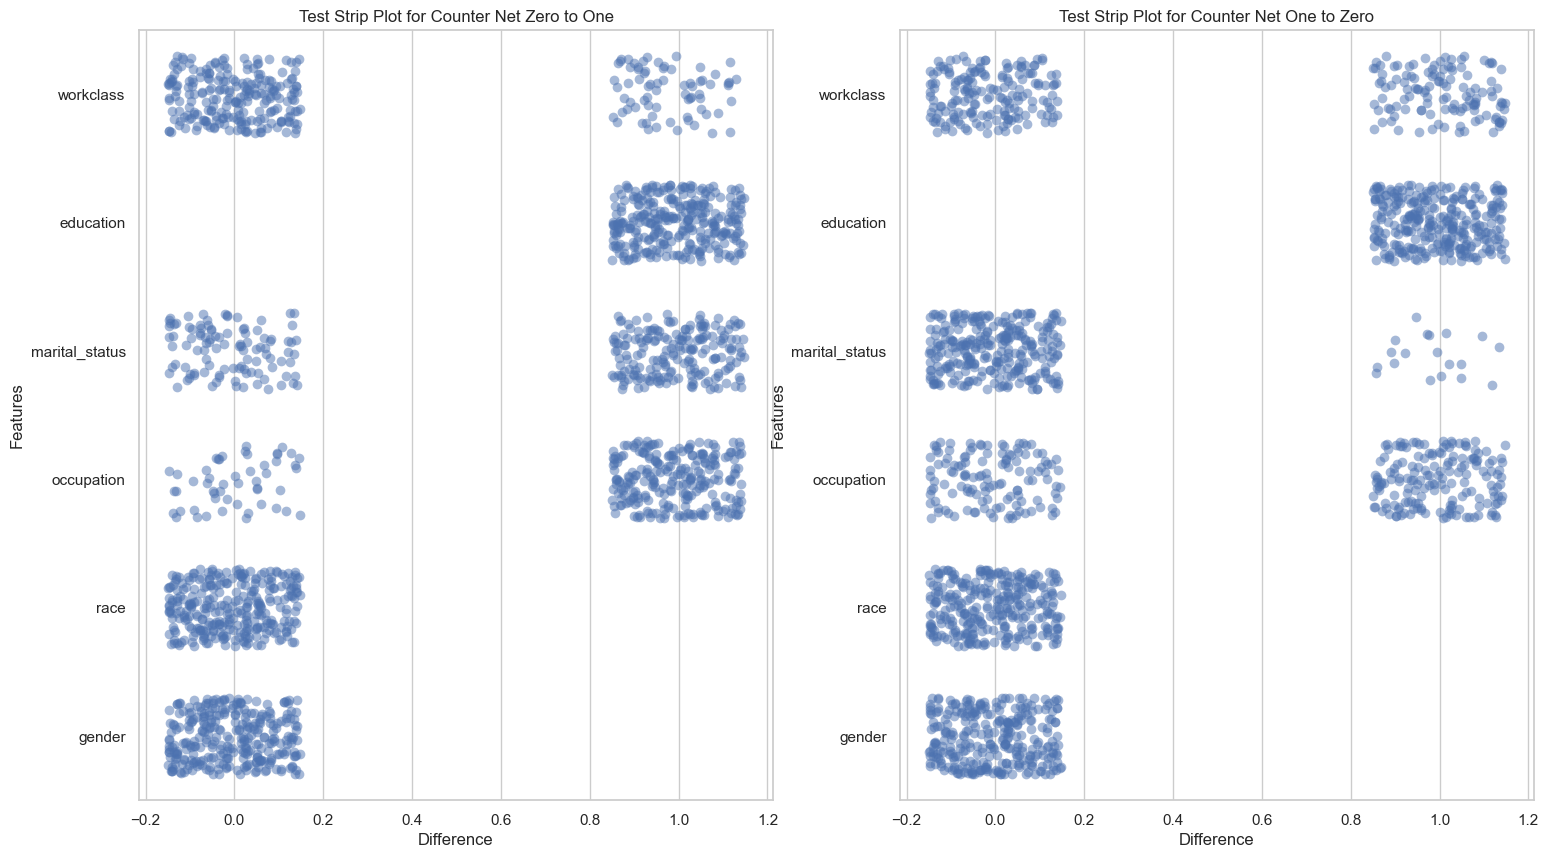

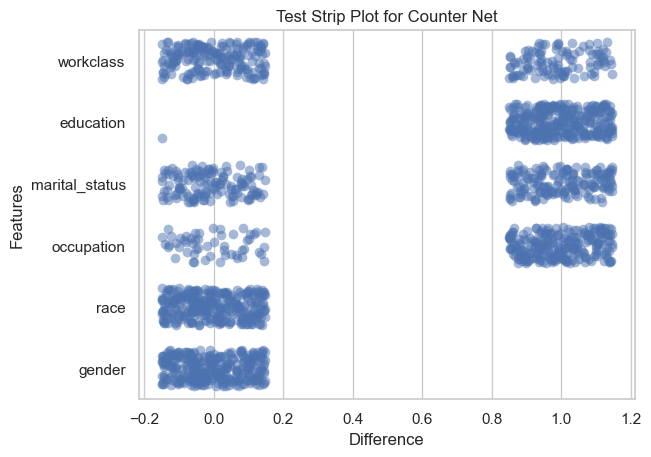

In [ ]:
#| slow
X, y = counternet_exp.data_module.test_dataset[:]
stripplot(X, counternet_exp.cfs, dm, "Test Strip Plot for Counter Net", 300, 42, True, counternet_exp.pred_fn)
stripplot(X, counternet_exp.cfs, dm, "Test Strip Plot for Counter Net", 300, 42, False, counternet_exp.pred_fn)